# Model 4: EfficientNet-B0 Transfer Learning
## Pneumonia Classification with 3-Fold Cross-Validation + Ensemble Prediction

**Architecture:** EfficientNet-B0 pretrained (ImageNet) - Feature Extraction Only
- Backbone completely frozen (no fine-tuning)
- Minimal head: Dense(64) → Dense(1, sigmoid)

**Optimizations:** 128×128 images, batch=8, mixed precision

**Ensemble Strategy:** Average predictions from all 3 folds

## 1. Setup & Configuration

In [1]:
import os, time, json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve
import warnings; warnings.filterwarnings('ignore')

print(f'TensorFlow: {tf.__version__}')
print(f'GPU: {tf.config.list_physical_devices("GPU")}')

TensorFlow: 2.10.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. GPU Memory Configuration

In [2]:
# GPU Config
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"Memory growth enabled for {len(gpus)} GPU(s)")

#tf.keras.mixed_precision.set_global_policy('mixed_float16')
#print(f'Mixed precision: {tf.keras.mixed_precision.global_policy()}')

Memory growth enabled for 1 GPU(s)


## 3. Configuration Parameters

In [3]:
# Config
BASE_DIR = Path('chest_xray')
TRAIN_DIR, VAL_DIR, TEST_DIR = BASE_DIR/'train', BASE_DIR/'val', BASE_DIR/'test'
IMG_SIZE, BATCH_SIZE = 128, 8
EPOCHS, N_FOLDS, PATIENCE = 20, 3, 5
RANDOM_STATE = 42
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']
CLASS_MAP = {'NORMAL': 0, 'PNEUMONIA': 1}

print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Max Epochs: {EPOCHS}")
print(f"CV Folds: {N_FOLDS}")

Image Size: 128x128
Batch Size: 8
Max Epochs: 20
CV Folds: 3


## 4. Data Loading

In [4]:
# Load data
def load_data_paths(dirs):
    paths, labels = [], []
    for d in dirs:
        for cn in CLASS_NAMES:
            cd = d / cn
            if cd.exists():
                for p in cd.glob('*'):
                    if p.suffix.lower() in ['.jpeg','.jpg','.png']:
                        paths.append(str(p)); labels.append(CLASS_MAP[cn])
    return np.array(paths), np.array(labels)

train_val_paths, train_val_labels = load_data_paths([TRAIN_DIR, VAL_DIR])
test_paths, test_labels = load_data_paths([TEST_DIR])

print(f'Train+Val: {len(train_val_paths)} images')
print(f'  - Normal: {np.sum(train_val_labels == 0)}')
print(f'  - Pneumonia: {np.sum(train_val_labels == 1)}')
print(f'Test: {len(test_paths)} images')

Train+Val: 5232 images
  - Normal: 1349
  - Pneumonia: 3883
Test: 624 images


## 5. Data Preprocessing & Augmentation

In [5]:
# Dataset
def create_dataset(paths, labels, bs, augment=False, shuffle=True):
    

    def load_img(p, l):
        img = tf.io.read_file(p)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = preprocess_input(tf.cast(img, tf.float32))  # ✅ AJOUT CRUCIAL
        return img, l
    
    def aug(img, l):
        img = tf.image.random_brightness(img, 25.5)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        cs = tf.random.uniform([], int(IMG_SIZE*0.85), IMG_SIZE, dtype=tf.int32)
        img = tf.image.random_crop(img, [cs, cs, 3])
        return tf.image.resize(img, [IMG_SIZE, IMG_SIZE]), l
    
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle: ds = ds.shuffle(len(paths), seed=RANDOM_STATE)
    ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    if augment: ds = ds.map(aug, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(bs).prefetch(tf.data.AUTOTUNE)

print("Dataset functions defined.")

Dataset functions defined.


## 6. EfficientNet-B0 Model Architecture

In [6]:
# Model
def create_efficientnet():
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    base.trainable = False
    inp = keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    x = base(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    return keras.Model(inp, out)

model = create_efficientnet()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                0     

## 7. Training with 3-Fold Cross-Validation

In [7]:
# Class weights - convert to float to avoid TF tensor serialization issues
cw_arr = compute_class_weight('balanced', classes=np.unique(train_val_labels), y=train_val_labels)
class_weights = {i: float(w) for i, w in enumerate(cw_arr)}
print(f'Class weights: {class_weights}')

Class weights: {0: 1.939214232765011, 1: 0.6737058975019315}


In [8]:
# 3-Fold CV - Using save_weights() to avoid TF 2.10 serialization bug
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
fold_results, fold_histories = [], []
all_val_preds, all_val_labels = [], []
total_start = time.time()

for fold, (tr_idx, val_idx) in enumerate(skf.split(train_val_paths, train_val_labels)):
    print(f'\n{"="*50}\nFOLD {fold+1}/{N_FOLDS}\n{"="*50}')
    fold_start = time.time()
    
    X_tr, X_val = train_val_paths[tr_idx], train_val_paths[val_idx]
    y_tr, y_val = train_val_labels[tr_idx], train_val_labels[val_idx]
    
    print(f"Training samples: {len(X_tr)}")
    print(f"Validation samples: {len(X_val)}")
    
    train_ds = create_dataset(X_tr, y_tr, BATCH_SIZE, augment=True)
    val_ds = create_dataset(X_val, y_val, BATCH_SIZE, augment=False, shuffle=False)
    
    tf.keras.backend.clear_session()
    model = create_efficientnet()
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy',
                  metrics=['accuracy', keras.metrics.AUC(name='auc')])
    cbs = [callbacks.EarlyStopping('val_loss', patience=PATIENCE, restore_best_weights=True),
           callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=3, min_lr=1e-7)]
    
    h = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, class_weight=class_weights,
                  callbacks=cbs, verbose=1)
    fold_histories.append(h.history)
    
    preds_p = model.predict(val_ds, verbose=0)
    preds = (preds_p>0.5).astype(int).flatten()
    all_val_preds.extend(preds)
    all_val_labels.extend(y_val)
    
    acc, auc, prec, rec, f1 = (accuracy_score(y_val,preds), roc_auc_score(y_val,preds_p),
                               precision_score(y_val,preds), recall_score(y_val,preds), f1_score(y_val,preds))
    ft = time.time()-fold_start
    
    fold_results.append({'fold':fold+1,'accuracy':acc,'auc':auc,'precision':prec,'recall':rec,'f1':f1,'time':ft})
    print(f'\nFold {fold+1} Results: Acc:{acc:.4f} AUC:{auc:.4f} F1:{f1:.4f} Time:{ft/60:.1f}min')
    
    # Save weights only (avoids TF 2.10 JSON serialization bug with mixed precision)
    model.save_weights(f'model_4_efficientnet_fold_{fold+1}_weights.h5')
    print(f'Weights saved: model_4_efficientnet_fold_{fold+1}_weights.h5')

total_time = time.time()-total_start
print(f'\n{"="*60}\nTOTAL TIME: {total_time/60:.2f} min\n{"="*60}')


FOLD 1/3
Training samples: 3488
Validation samples: 1744
Epoch 1/20
436/436 [==============================] - 31s 41ms/step - loss: 0.2991 - accuracy: 0.8627 - auc: 0.9460 - val_loss: 0.2214 - val_accuracy: 0.9037 - val_auc: 0.9801 - lr: 0.0010
Epoch 2/20
436/436 [==============================] - 17s 38ms/step - loss: 0.2508 - accuracy: 0.8902 - auc: 0.9608 - val_loss: 0.1571 - val_accuracy: 0.9312 - val_auc: 0.9901 - lr: 0.0010
Epoch 3/20
436/436 [==============================] - 18s 40ms/step - loss: 0.2149 - accuracy: 0.9100 - auc: 0.9713 - val_loss: 0.2195 - val_accuracy: 0.9100 - val_auc: 0.9908 - lr: 0.0010
Epoch 4/20
436/436 [==============================] - 17s 39ms/step - loss: 0.1947 - accuracy: 0.9180 - auc: 0.9760 - val_loss: 0.2312 - val_accuracy: 0.9054 - val_auc: 0.9925 - lr: 0.0010
Epoch 5/20
436/436 [==============================] - 17s 38ms/step - loss: 0.1833 - accuracy: 0.9229 - auc: 0.9791 - val_loss: 0.1894 - val_accuracy: 0.9203 - val_auc: 0.9919 - lr: 0.00

## 8. Training Curves Visualization

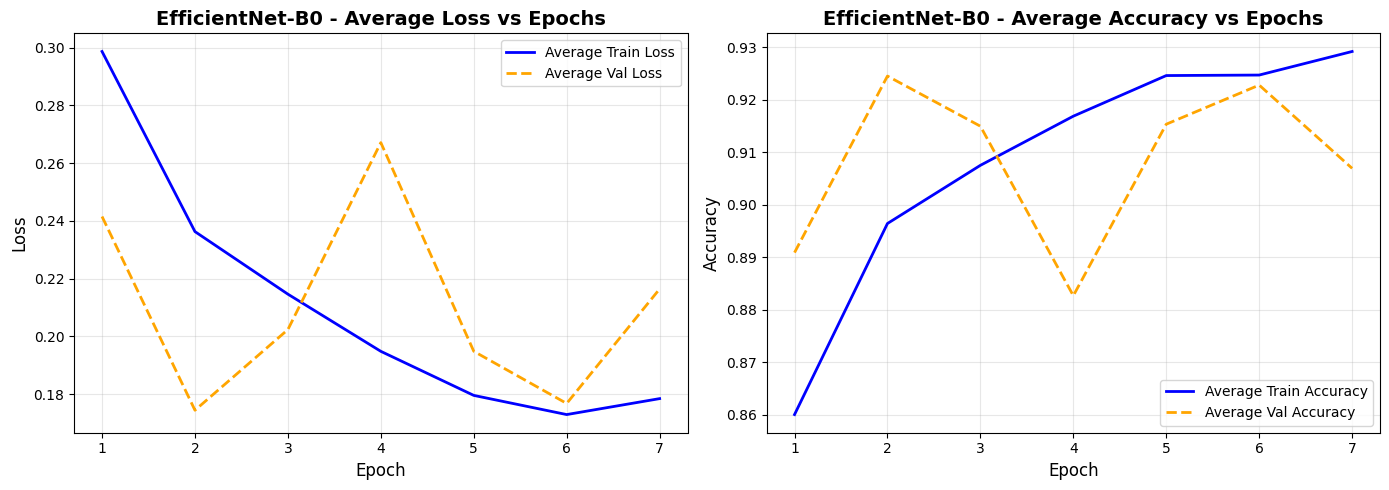

In [9]:
# Plot Average Loss & Accuracy curves
def get_avg_history(histories, metric):
    min_len = min([len(h[metric]) for h in histories])
    values = [h[metric][:min_len] for h in histories]
    return np.mean(values, axis=0), range(1, min_len+1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
avg_loss, eps = get_avg_history(fold_histories, 'loss')
avg_val_loss, _ = get_avg_history(fold_histories, 'val_loss')
axes[0].plot(eps, avg_loss, label='Average Train Loss', linewidth=2, color='blue')
axes[0].plot(eps, avg_val_loss, '--', label='Average Val Loss', linewidth=2, color='orange')
axes[0].set_xlabel('Epoch', fontsize=12); axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('EfficientNet-B0 - Average Loss vs Epochs', fontsize=14, fontweight='bold')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Accuracy
avg_acc, _ = get_avg_history(fold_histories, 'accuracy')
avg_val_acc, _ = get_avg_history(fold_histories, 'val_accuracy')
axes[1].plot(eps, avg_acc, label='Average Train Accuracy', linewidth=2, color='blue')
axes[1].plot(eps, avg_val_acc, '--', label='Average Val Accuracy', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontsize=12); axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('EfficientNet-B0 - Average Accuracy vs Epochs', fontsize=14, fontweight='bold')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_4_efficientnet_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

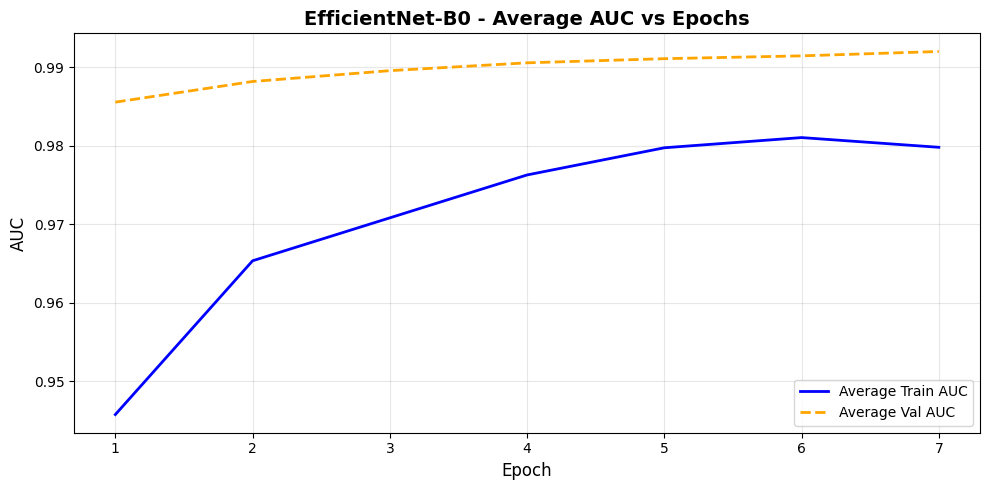

In [10]:
# Plot Average AUC curves
plt.figure(figsize=(10, 5))
avg_auc, eps = get_avg_history(fold_histories, 'auc')
avg_val_auc, _ = get_avg_history(fold_histories, 'val_auc')
plt.plot(eps, avg_auc, label='Average Train AUC', linewidth=2, color='blue')
plt.plot(eps, avg_val_auc, '--', label='Average Val AUC', linewidth=2, color='orange')
plt.xlabel('Epoch', fontsize=12); plt.ylabel('AUC', fontsize=12)
plt.title('EfficientNet-B0 - Average AUC vs Epochs', fontsize=14, fontweight='bold')
plt.legend(loc='lower right'); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_4_efficientnet_auc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Cross-Validation Results Summary

In [11]:
# Results
df = pd.DataFrame(fold_results)
print('\n' + '='*60)
print('3-FOLD CROSS-VALIDATION RESULTS')
print('='*60)
print(df.to_string(index=False))

print('\n' + '-'*60)
print('AVERAGE METRICS (Mean ± Std)')
print('-'*60)
for m in ['accuracy','auc','precision','recall','f1']:
    print(f'{m.capitalize():12}: {df[m].mean():.4f} ± {df[m].std():.4f}')
print(f'\nTotal Training Time: {total_time/60:.2f} min')


3-FOLD CROSS-VALIDATION RESULTS
 fold  accuracy      auc  precision   recall       f1       time
    1  0.931193 0.990125   0.989167 0.917311 0.951885 143.310661
    2  0.947248 0.990771   0.989414 0.938949 0.963521 148.558966
    3  0.924885 0.990083   0.991554 0.906564 0.947156 180.391322

------------------------------------------------------------
AVERAGE METRICS (Mean ± Std)
------------------------------------------------------------
Accuracy    : 0.9344 ± 0.0115
Auc         : 0.9903 ± 0.0004
Precision   : 0.9900 ± 0.0013
Recall      : 0.9209 ± 0.0165
F1          : 0.9542 ± 0.0084

Total Training Time: 7.88 min


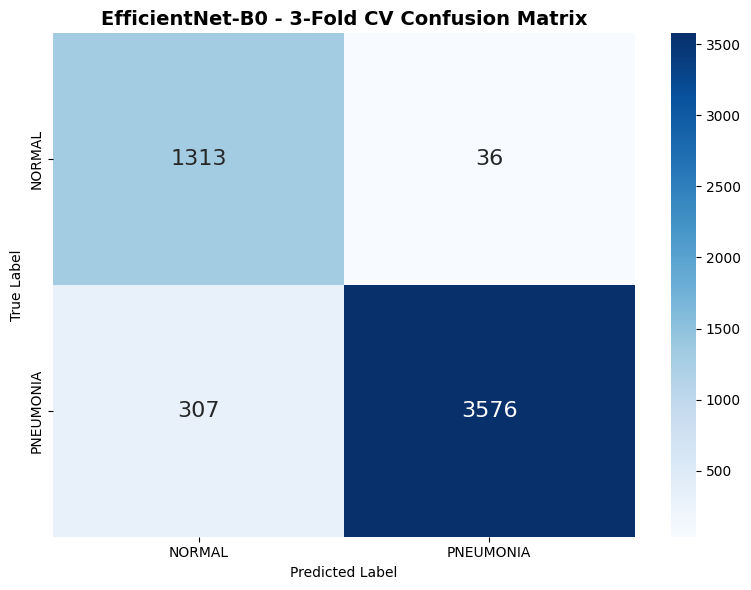


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.81      0.97      0.88      1349
   PNEUMONIA       0.99      0.92      0.95      3883

    accuracy                           0.93      5232
   macro avg       0.90      0.95      0.92      5232
weighted avg       0.94      0.93      0.94      5232



In [12]:
# CV Confusion Matrix
cm = confusion_matrix(all_val_labels, all_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            annot_kws={'size': 16})
plt.title('EfficientNet-B0 - 3-Fold CV Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('model_4_efficientnet_cv_cm.png', dpi=150)
plt.show()

print('\nClassification Report:')
print(classification_report(all_val_labels, all_val_preds, target_names=CLASS_NAMES))

## 10. Ensemble Prediction on Test Set

**Strategy:** Load all 3 fold models, predict on test set, and average predictions for better robustness.

In [13]:
print("="*60)
print("ENSEMBLE PREDICTION - Loading all 3 fold models")
print("="*60)

# Load all 3 models by recreating architecture and loading weights
ensemble_models = []
for fold in range(1, N_FOLDS + 1):
    weights_path = f'model_4_efficientnet_fold_{fold}_weights.h5'
    print(f"Loading {weights_path}...")
    model = create_efficientnet()
    model.load_weights(weights_path)
    ensemble_models.append(model)
print(f"\nLoaded {len(ensemble_models)} models for ensemble.")

ENSEMBLE PREDICTION - Loading all 3 fold models
Loading model_4_efficientnet_fold_1_weights.h5...
Loading model_4_efficientnet_fold_2_weights.h5...
Loading model_4_efficientnet_fold_3_weights.h5...

Loaded 3 models for ensemble.


In [14]:
# Create test dataset
test_ds = create_dataset(test_paths, test_labels, BATCH_SIZE, augment=False, shuffle=False)

# Predict with each model
print("\nMaking predictions with each model...")
all_test_preds = []
for i, model in enumerate(ensemble_models):
    print(f"  Predicting with Fold {i+1} model...")
    preds = model.predict(test_ds, verbose=0)
    all_test_preds.append(preds)
    print(f"    Mean prediction: {np.mean(preds):.4f}")

# Average predictions (Ensemble)
print("\nAveraging predictions from all 3 models...")
ensemble_preds_proba = np.mean(all_test_preds, axis=0)
ensemble_preds = (ensemble_preds_proba > 0.5).astype(int).flatten()

print(f"Ensemble mean prediction: {np.mean(ensemble_preds_proba):.4f}")


Making predictions with each model...
  Predicting with Fold 1 model...
    Mean prediction: 0.7011
  Predicting with Fold 2 model...
    Mean prediction: 0.7125
  Predicting with Fold 3 model...
    Mean prediction: 0.6524

Averaging predictions from all 3 models...
Ensemble mean prediction: 0.6886


In [15]:
# Calculate ensemble test metrics
test_acc = accuracy_score(test_labels, ensemble_preds)
test_auc = roc_auc_score(test_labels, ensemble_preds_proba)
test_prec = precision_score(test_labels, ensemble_preds)
test_rec = recall_score(test_labels, ensemble_preds)
test_f1 = f1_score(test_labels, ensemble_preds)

tn,fp,fn,tp = confusion_matrix(test_labels, ensemble_preds).ravel()
spec, sens = tn/(tn+fp), tp/(tp+fn)

print("\n" + "="*60)
print("ENSEMBLE TEST SET RESULTS")
print("="*60)
print(f'Accuracy:    {test_acc:.4f}')
print(f'AUC-ROC:     {test_auc:.4f}')
print(f'Precision:   {test_prec:.4f}')
print(f'Recall:      {test_rec:.4f}')
print(f'F1-Score:    {test_f1:.4f}')
print(f'Sensitivity: {sens:.4f} (Pneumonia detection)')
print(f'Specificity: {spec:.4f} (Normal detection)')


ENSEMBLE TEST SET RESULTS
Accuracy:    0.8862
AUC-ROC:     0.9603
Precision:   0.8718
Recall:      0.9590
F1-Score:    0.9133
Sensitivity: 0.9590 (Pneumonia detection)
Specificity: 0.7650 (Normal detection)


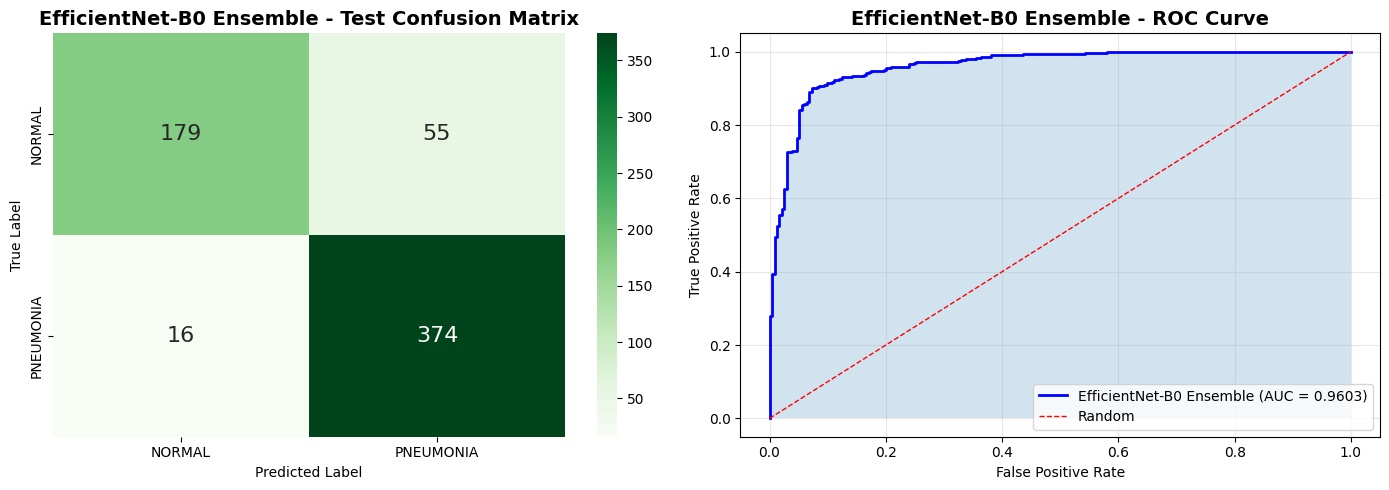


Test Classification Report (Ensemble):
              precision    recall  f1-score   support

      NORMAL       0.92      0.76      0.83       234
   PNEUMONIA       0.87      0.96      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.86      0.87       624
weighted avg       0.89      0.89      0.88       624



In [16]:
# Test Confusion Matrix + ROC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CM
cm_test = confusion_matrix(test_labels, ensemble_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=axes[0], annot_kws={'size': 16})
axes[0].set_title('EfficientNet-B0 Ensemble - Test Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label'); axes[0].set_xlabel('Predicted Label')

# ROC
fpr, tpr, _ = roc_curve(test_labels, ensemble_preds_proba)
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'EfficientNet-B0 Ensemble (AUC = {test_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
axes[1].fill_between(fpr, tpr, alpha=0.2)
axes[1].set_xlabel('False Positive Rate'); axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('EfficientNet-B0 Ensemble - ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right'); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_4_efficientnet_ensemble_test_results.png', dpi=150)
plt.show()

print('\nTest Classification Report (Ensemble):')
print(classification_report(test_labels, ensemble_preds, target_names=CLASS_NAMES))

## 11. Save Final Results

In [17]:
# Save results to JSON
results = {
    'model': 'EfficientNet-B0 - Ensemble',
    'ensemble_strategy': 'Average predictions from 3 fold models',
    'total_time_min': float(total_time/60),
    'cv': {
        'accuracy_mean': float(df['accuracy'].mean()),
        'accuracy_std': float(df['accuracy'].std()),
        'auc_mean': float(df['auc'].mean()),
        'auc_std': float(df['auc'].std()),
        'f1_mean': float(df['f1'].mean()),
        'f1_std': float(df['f1'].std())
    },
    'test_ensemble': {
        'accuracy': float(test_acc),
        'auc': float(test_auc),
        'precision': float(test_prec),
        'recall': float(test_rec),
        'f1': float(test_f1),
        'sensitivity': float(sens),
        'specificity': float(spec)
    }
}

with open('model_4_efficientnet_ensemble_results.json','w') as f:
    json.dump(results, f, indent=2)

print('Results saved to model_4_efficientnet_ensemble_results.json')
print('\n' + '='*60)
print('MODEL 4: EfficientNet-B0 ENSEMBLE - COMPLETE')
print('='*60)

Results saved to model_4_efficientnet_ensemble_results.json

MODEL 4: EfficientNet-B0 ENSEMBLE - COMPLETE
